In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import src.config as config
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def train_model_cv(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
    print("CV Scores:", cv_score)

    acc_mean = cv_score.mean()
    acc_std = cv_score.std()
    print(f"CV Score: {acc_mean:.4f}+-{acc_std:.4f}")

    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    print("Validation Accuracy:", acc_val)

    # Predict
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc_test)
    return model, acc_mean, acc_val, acc_test


def train_extracted_features(MODEL_NAME):
    INPUT_PATH = config.OUTPUT_FEATTOP_DATA

    TRAIN_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'train.csv')
    TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_train.csv')
    VAL_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'valid.csv')
    VAL_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_valid.csv')
    TEST_DATA_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'test.csv')
    TEST_LABELS_PATH = os.path.join(INPUT_PATH, MODEL_NAME, 'y_test.csv')

    X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)
    X_valid_prep, y_valid = pd.read_csv(VAL_DATA_PATH), pd.read_csv(VAL_LABELS_PATH)
    X_test_prep, y_test = pd.read_csv(TEST_DATA_PATH), pd.read_csv(TEST_LABELS_PATH)

    ls_feats_umap = [col for col in X_train_prep.columns if 'umap' in col]

    sc = StandardScaler()
    X_train_prep[ls_feats_umap] = sc.fit_transform(X_train_prep[ls_feats_umap])
    X_valid_prep[ls_feats_umap] = sc.transform(X_valid_prep[ls_feats_umap])
    X_test_prep[ls_feats_umap] = sc.transform(X_test_prep[ls_feats_umap])

    xgb = XGBClassifier(n_jobs=-1)
    lsvm = LinearSVC(dual='auto')
    svm = SVC()
    rf = RandomForestClassifier(n_jobs=-1)
    vc = VotingClassifier(estimators=[('xgb', xgb), ('lsvm', lsvm), 
                                      ('svm', svm), ('rf', rf)], 
                          voting='hard', n_jobs=-1)

    ls_models = [xgb, lsvm, svm, rf, vc]
    d_results = {}
    for model in ls_models:
        print("Model:", model.__class__.__name__)
        model, acc_mean, acc_val, acc_test = train_model_cv(model, X_train_prep, y_train, 
                                                            X_valid_prep, y_valid, X_test_prep, y_test)
        d_results[model.__class__.__name__] = {'model_name': model.__class__.__name__, 
                                               'trained_model': model, 'CV_accuracy': acc_mean,
                                                'val_accuracy': acc_val, 'test_accuracy': acc_test}
        
    return d_results

model_names = ["ResNet50", "VGG16", "EfficientNetB0", "EfficientNetB3"]

df_model_comp = pd.DataFrame()
for model_name in model_names:
    print("Model:", model_name)
    d_ex = train_extracted_features(model_name)
    df_ = pd.DataFrame(d_ex).T
    df_["extractor"] = model_name
    df_model_comp = pd.concat([df_model_comp, df_], ignore_index=True)

df_model_comp

Model: ResNet50
Model: XGBClassifier
CV Scores: [0.95123153 0.95689655 0.95394089 0.95935961 0.77438424]
CV Score: 0.9192+-0.0724
Validation Accuracy: 0.6675862068965517
Test Accuracy: 0.6443763173021652
Model: LinearSVC
CV Scores: [0.84876847 0.86009852 0.85837438 0.8773399  0.57463054]
CV Score: 0.8038+-0.1150
Validation Accuracy: 0.6317241379310344
Test Accuracy: 0.6110365970492432
Model: SVC
CV Scores: [0.91477833 0.92660099 0.91724138 0.91527094 0.71256158]
CV Score: 0.8773+-0.0825
Validation Accuracy: 0.6606896551724138
Test Accuracy: 0.6441208405186178
Model: RandomForestClassifier
CV Scores: [0.95591133 0.95960591 0.95714286 0.96157635 0.76551724]
CV Score: 0.9200+-0.0772
Validation Accuracy: 0.6737931034482758
Test Accuracy: 0.6404802963530689
Model: VotingClassifier
CV Scores: [0.94408867 0.94901478 0.94334975 0.9455665  0.70738916]
CV Score: 0.8979+-0.0953
Validation Accuracy: 0.6662068965517242
Test Accuracy: 0.6476336462923932
Model: VGG16
Model: XGBClassifier
CV Scores: [

,model_name,trained_model,CV_accuracy,val_accuracy,test_accuracy,extractor
0,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.919163,0.667586,0.644376,ResNet50
1,LinearSVC,LinearSVC(dual='auto'),0.803842,0.631724,0.611037,ResNet50
2,SVC,SVC(),0.877291,0.66069,0.644121,ResNet50
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.919951,0.673793,0.64048,ResNet50
4,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.897882,0.666207,0.647634,ResNet50
5,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.919261,0.664828,0.642013,VGG16
6,LinearSVC,LinearSVC(dual='auto'),0.791379,0.62,0.602223,VGG16
7,SVC,SVC(),0.875271,0.655172,0.639267,VGG16
8,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.918916,0.666207,0.63882,VGG16
9,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.896995,0.663448,0.644951,VGG16


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Feature Extraction Model Comparison')

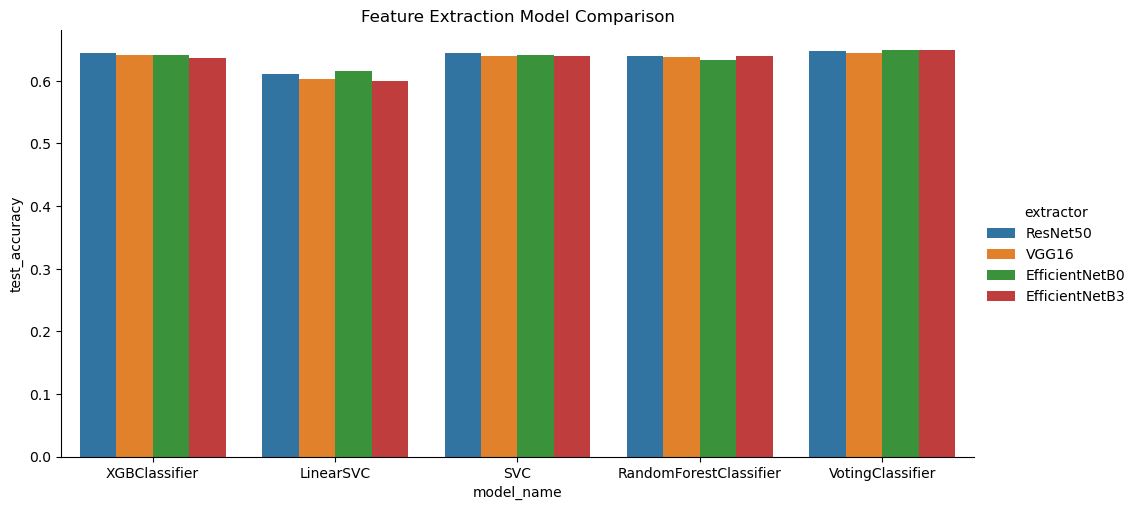

In [2]:
df_model_aux = df_model_comp[['extractor', 'model_name', 'test_accuracy']].copy()
# df_model_aux.set_index(['extractor'], inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=df_model_aux, kind='bar', x='model_name', y='test_accuracy', hue='extractor',
            height=5, aspect=2, legend=True);

plt.title("Feature Extraction Model Comparison")

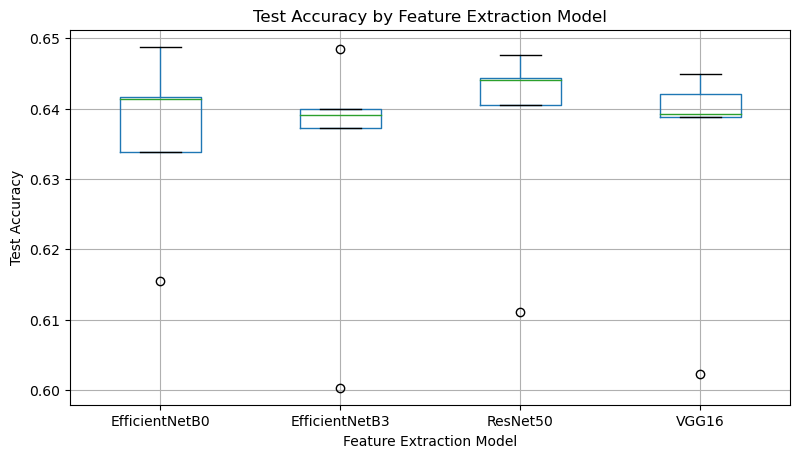

In [3]:
df_model_comp.boxplot(column='test_accuracy', by='extractor', figsize=(9, 5))
plt.title("Test Accuracy by Feature Extraction Model")
plt.xlabel("Feature Extraction Model")
plt.ylabel("Test Accuracy")
plt.suptitle("");

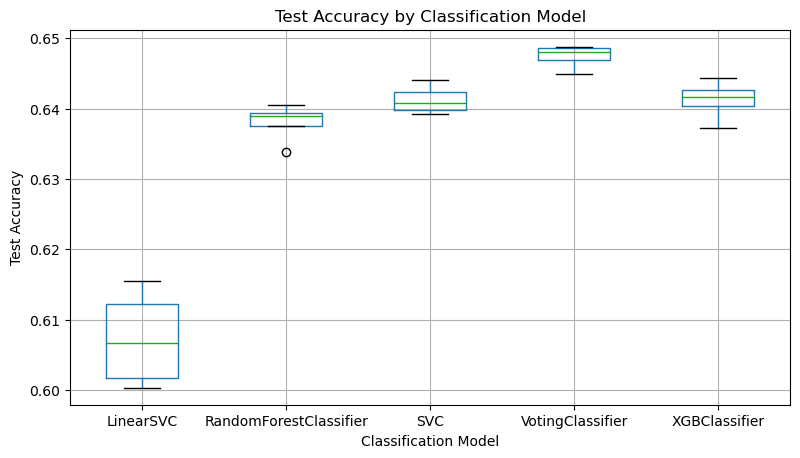

In [4]:
df_model_comp.boxplot(column='test_accuracy', by='model_name', figsize=(9, 5))
plt.title("Test Accuracy by Classification Model")
plt.xlabel("Classification Model")
plt.ylabel("Test Accuracy")
plt.suptitle("");

In [ ]:
xgb.feature_names_in_

Text(0.5, 1.0, 'Feature Importance for EfficientNetB3 + XGBoost')

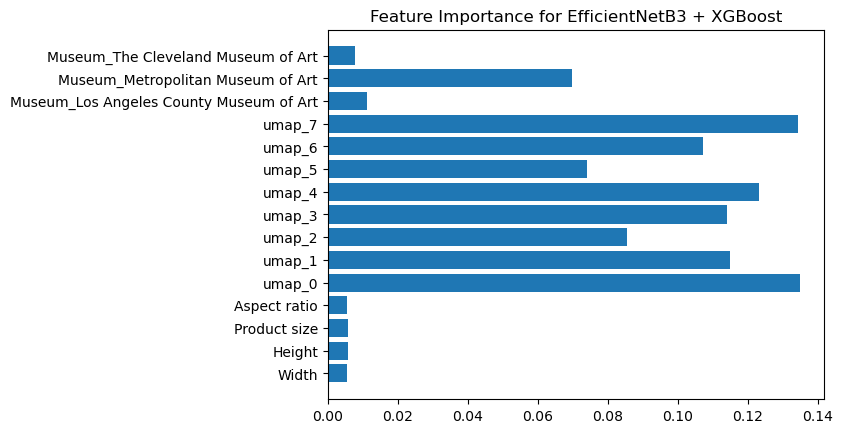

In [5]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
xgb_imp = df_effb3[df_effb3["model_name"] == 'XGBClassifier']['trained_model'].iloc[0]

plt.barh(xgb_imp.feature_names_in_, xgb_imp.feature_importances_)
plt.title("Feature Importance for EfficientNetB3 + XGBoost")

Text(0.5, 1.0, 'Feature Importance for EfficientNetB3 + RandomForestClassifier')

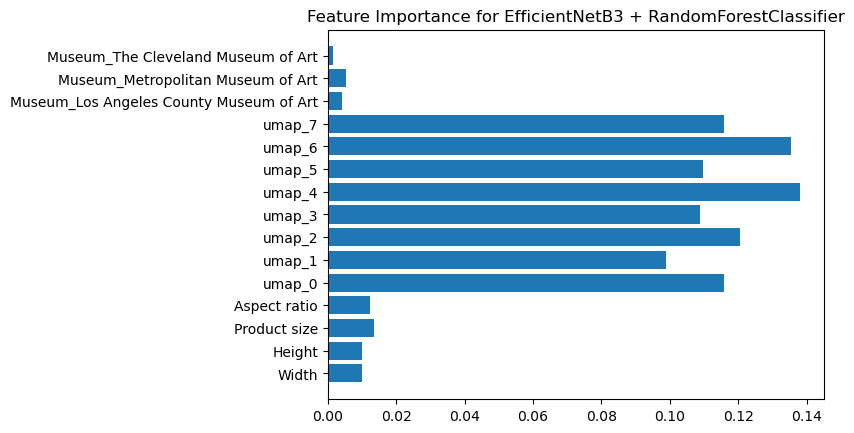

In [11]:
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
rf_imp = df_effb3[df_effb3["model_name"] == 'RandomForestClassifier']['trained_model'].iloc[0]

plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
plt.title("Feature Importance for EfficientNetB3 + RandomForestClassifier")

In [12]:
import numpy as np
df_effb3 = df_model_comp[df_model_comp['extractor'] == 'EfficientNetB3']
lsvc_imp = df_effb3[df_effb3["model_name"] == 'LinearSVC']['trained_model'].iloc[0].coef_
lsvc_imp = np.abs(lsvc_imp.mean(axis=0)) / np.abs(lsvc_imp.mean(axis=0)).sum()

# plt.barh(rf_imp.feature_names_in_, rf_imp.feature_importances_)
# plt.title("Feature Importance for EfficientNetB3 + RandomForestClassifier")


In [13]:
lsvc_imp

array([0.01977699, 0.00284277, 0.04342081, 0.00693807, 0.00364205,
       0.09407919, 0.00255211, 0.05164776, 0.05030305, 0.0181433 ,
       0.01608942, 0.02655314, 0.24615951, 0.20207987, 0.21577195])

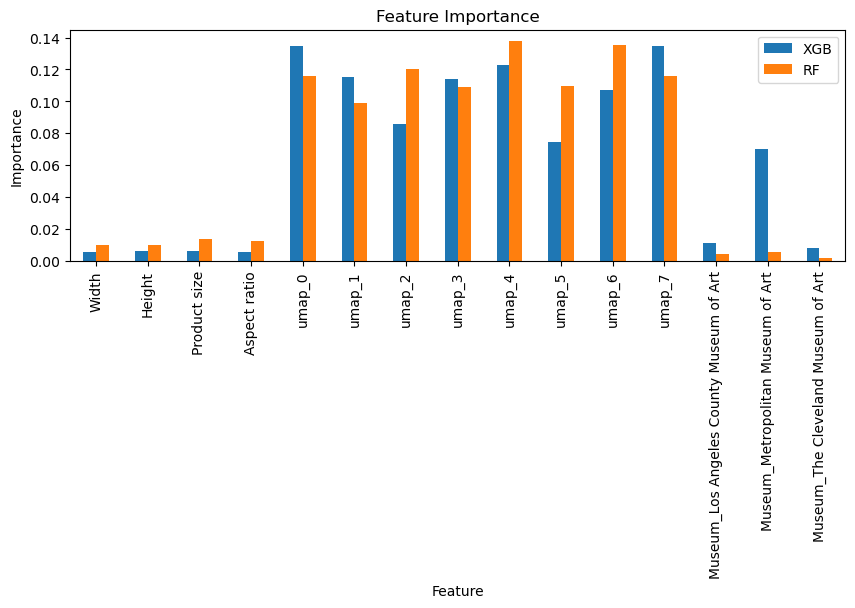

In [15]:
df_imp = pd.DataFrame({'XGB': xgb_imp.feature_importances_, 'RF': rf_imp.feature_importances_}, index=xgb_imp.feature_names_in_)
# df_imp = df_imp.sort_values(by='XGB', ascending=False)
df_imp.plot(kind='bar', figsize=(10, 3), title='Feature Importance', xlabel='Feature', ylabel='Importance');

In [17]:
# Load X_train, y_train, X_test, y_test
INPUT_PATH = config.OUTPUT_FEATTOP_DATA

TRAIN_DATA_PATH = os.path.join(INPUT_PATH, 'EfficientNetB3', 'train.csv')
TRAIN_LABELS_PATH = os.path.join(INPUT_PATH, 'EfficientNetB3', 'y_train.csv')


X_train_prep, y_train = pd.read_csv(TRAIN_DATA_PATH), pd.read_csv(TRAIN_LABELS_PATH)

In [23]:
X_train_prep[umap_feats]

,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7
0,8.861486,5.687942,3.542317,10.503372,6.342788,10.244471,-2.598467,-0.004810
1,9.275366,5.785476,3.288392,10.522595,6.079661,10.244962,-2.477178,-0.448478
2,9.017611,5.871374,3.413760,10.477140,6.170753,10.176578,-2.594188,-0.191072
3,8.888192,5.826143,3.442809,10.432126,6.368913,10.112333,-2.111128,0.081855
4,8.223749,5.837707,3.844190,10.156062,6.772964,9.894257,-1.721457,0.829581
...,...,...,...,...,...,...,...,...
20295,11.624775,2.277772,3.691400,11.166593,9.297000,14.736204,-0.346267,-4.660994
20296,11.547504,2.272046,3.752462,11.192346,9.298937,14.809742,-0.430908,-4.684768
20297,11.672392,2.287406,3.632502,11.123696,9.221782,14.788664,-0.369457,-4.701803
20298,11.718847,2.132331,3.667454,11.254521,9.445282,14.567406,-0.235256,-4.713800


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


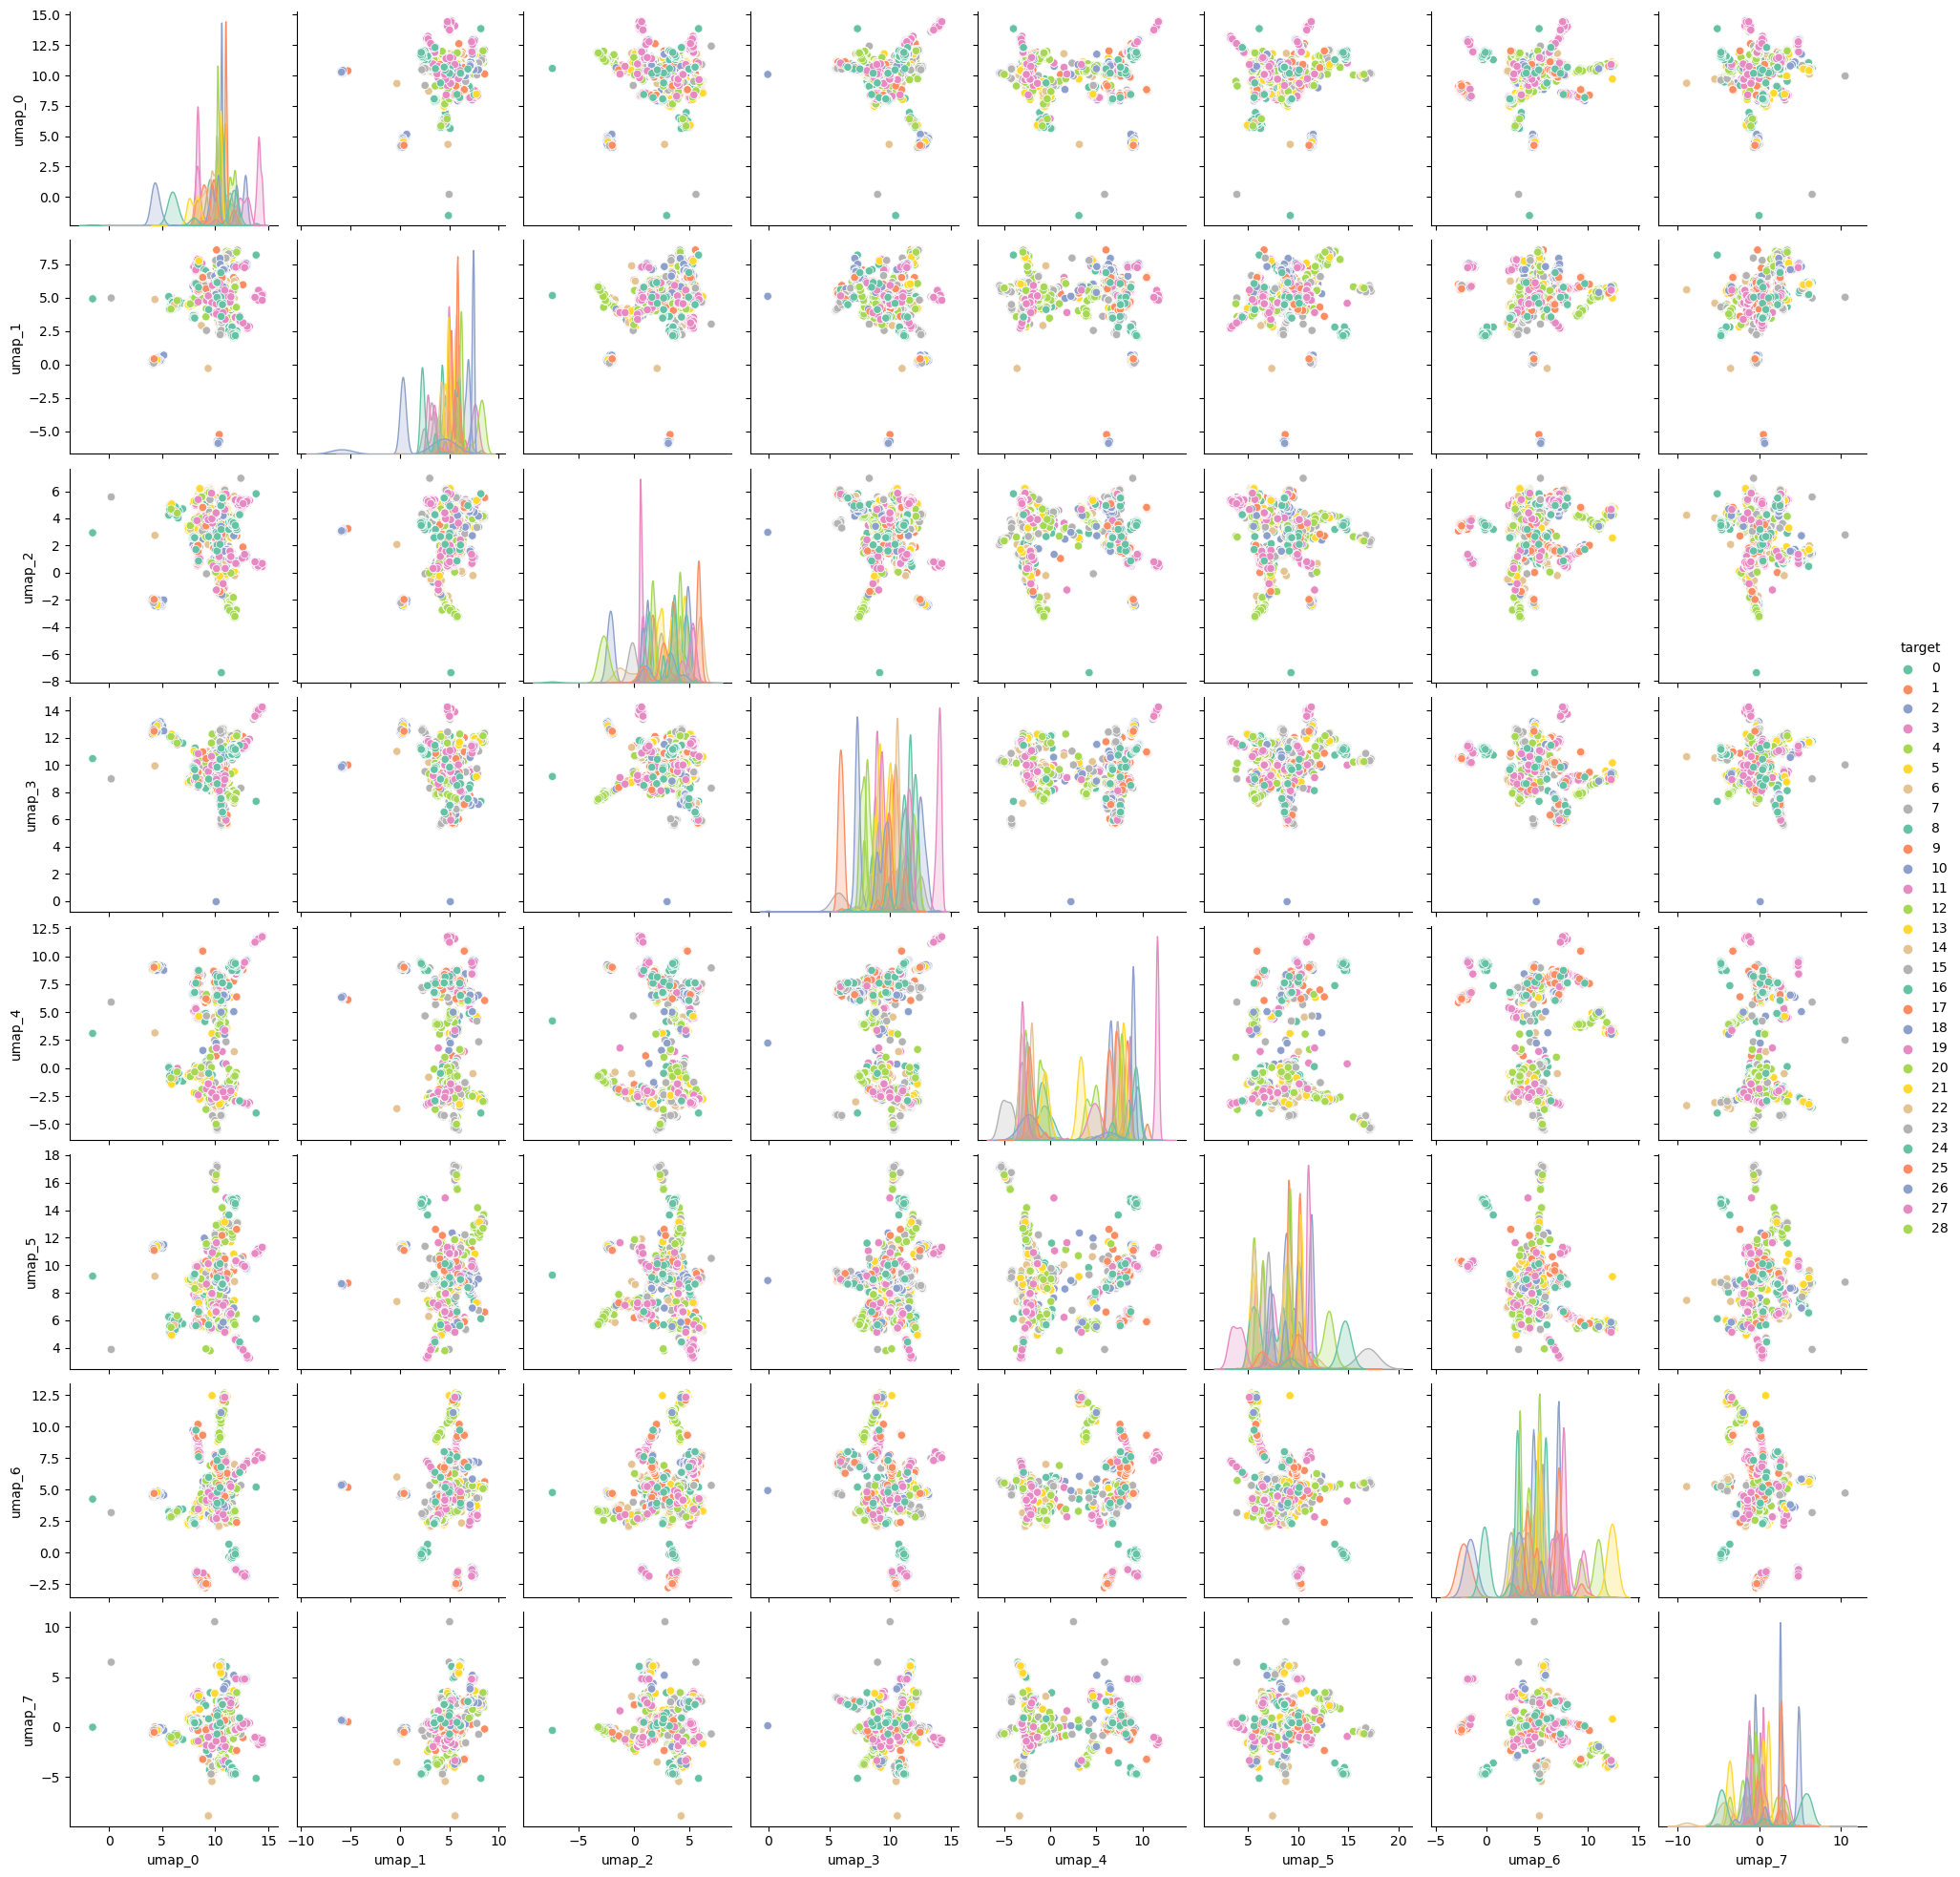

In [29]:
umap_feats = [col for col in X_train_prep.columns if 'umap' in col]
df_plot = X_train_prep[umap_feats].copy()
df_plot['target'] = y_train
sns.pairplot(df_plot, hue='target', palette='Set2');

In [16]:
df_model_comp.sort_values(by='test_accuracy', ascending=False)

,model_name,trained_model,CV_accuracy,val_accuracy,test_accuracy,extractor
14,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.899015,0.668966,0.648783,EfficientNetB0
19,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.901379,0.663448,0.648528,EfficientNetB3
4,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.897882,0.666207,0.647634,ResNet50
9,VotingClassifier,"VotingClassifier(estimators=[('xgb',\n ...",0.896995,0.663448,0.644951,VGG16
0,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.919163,0.667586,0.644376,ResNet50
2,SVC,SVC(),0.877291,0.66069,0.644121,ResNet50
5,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.919261,0.664828,0.642013,VGG16
12,SVC,SVC(),0.876995,0.656552,0.641694,EfficientNetB0
10,XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...",0.921182,0.668966,0.641374,EfficientNetB0
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.919951,0.673793,0.64048,ResNet50


In [ ]:
xgb_imp = d_results['XGBClassifier']['model'].feature_importances_
rf_imp = d_results['RandomForestClassifier']['model'].feature_importances_
lsvc_imp = np.abs(d_results['LinearSVC']['model'].coef_).mean(axis=0)
lsvc_imp = lsvc_imp / lsvc_imp.sum()

In [55]:
from bayes_opt import BayesianOptimization, UtilityFunction
# Numpy import

import numpy as np



# SK Learn imports

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def internal_method(n_estimators, max_depth, learning_rate):

    # C: SVC hyper parameter to optimize for.
    model = XGBClassifier(n_jobs=-1, n_estimators=int(n_estimators), 
                          max_depth=int(max_depth), learning_rate=learning_rate,
                          random_state=7, )
    model.fit(X_train_prep, y_train.values.ravel())
    y_pred = model.predict(X_valid_prep)
    f = accuracy_score(y_valid.values.ravel(), y_pred)
    return f

# bayes_opt requires this to be a dictionary.
bds = {"n_estimators": (100, 1000),
       "max_depth": (1, 10),
       "learning_rate": (0.01, 1)}

# Create a BayesianOptimization optimizer and optimize the function
optimizer = BayesianOptimization(f = internal_method,
                                 pbounds = bds,
                                 random_state = 7,
                                 verbose=2)

optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6676    | 0.08555   | 8.019     | 494.6     |
| 2         | 0.6172    | 0.7262    | 9.802     | 584.6     |
| 3         | 0.6662    | 0.5061    | 1.648     | 341.6     |
| 4         | 0.6634    | 0.5049    | 7.113     | 823.4     |
| 5         | 0.6697    | 0.3871    | 1.593     | 359.3     |
| 6         | 0.6662    | 0.2844    | 1.984     | 357.9     |
| 7         | 0.669     | 0.3681    | 1.849     | 374.3     |
| 8         | 0.2428    | 1.0       | 1.0       | 321.4     |
| 9         | 0.669     | 0.1346    | 9.963     | 519.1     |
| 10        | 0.6614    | 0.03495   | 1.842     | 542.6     |


In [51]:
optimizer.max

{'target': 0.6358620689655172, 'params': {'C': 0.07262305260526318}}